- ### Documents used:
    - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model  import SGDClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.preprocessing import normalize
from memory_profiler import memory_usage

import pandas as pd
import numpy as np

from ML_loader import DatasetLoader,ModelLoader


In [8]:
#Get data 
loader = DatasetLoader()
loader.read_dataset('partial_database.csv',class_path='labelsDefault.txt',separator=',')
loader.split_dataset()

#Normalize data, if not already normalized
print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

(4048, 17) (1012, 17) (4048,) (1012,)


In [9]:
#Get model
model = ModelLoader()
model.set_model(SGDClassifier(tol=1e-05,penalty='elasticnet',max_iter=5000,loss='log',alpha=0.001,random_state=1,warm_start=True))

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

#Optimization 25 min, {'tol': 1e-05, 'penalty': 'elasticnet', 'max_iter': 5000, 'loss': 'log', 'alpha': 0.001}
"""param = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 5000, 10000, 20000],
        'tol': [1e-3, 1e-4, 1e-5]}

model.set_optimal_params(param)

model.optimize(loader.X_train,loader.y_train,cv=cv,scoring='accuracy',n_iter=10)

#Train model with optimal params
model.set_model(SGDClassifier(**model.optimal_params,random_state=1,warm_start=True))"""

"param = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],\n        'penalty': ['l2', 'l1', 'elasticnet'],\n        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],\n        'max_iter': [1000, 5000, 10000, 20000],\n        'tol': [1e-3, 1e-4, 1e-5]}\n\nmodel.set_optimal_params(param)\n\nmodel.optimize(loader.X_train,loader.y_train,cv=cv,scoring='accuracy',n_iter=10)\n\n#Train model with optimal params\nmodel.set_model(SGDClassifier(**model.optimal_params,random_state=1,warm_start=True))"

Partial fit


Score accuracy group 0:  0.8881987577639752
Score accuracy group learned 0:  0.8881987577639752
Score accuracy global:  0.30237154150197626
Memory:  258.4453125 MB
Partial fit
Score accuracy group 1:  1.0
Score accuracy group learned 0:  0.14285714285714285
Score accuracy group learned 1:  1.0
Score accuracy global:  0.14723320158102768
Memory:  262.2265625 MB
Partial fit
Score accuracy group 2:  0.7119565217391305
Score accuracy group learned 0:  0.10869565217391304
Score accuracy group learned 1:  0.0
Score accuracy group learned 2:  0.7119565217391305
Score accuracy global:  0.16600790513833993
Memory:  240.72265625 MB
Partial fit
Score accuracy group 3:  0.8188405797101449
Score accuracy group learned 0:  0.11180124223602485
Score accuracy group learned 1:  0.0
Score accuracy group learned 2:  0.0
Score accuracy group learned 3:  0.8188405797101449
Score accuracy global:  0.1492094861660079
Memory:  242.640625 MB
Partial fit
Score accuracy group 4:  0.9891304347826086
Score accurac

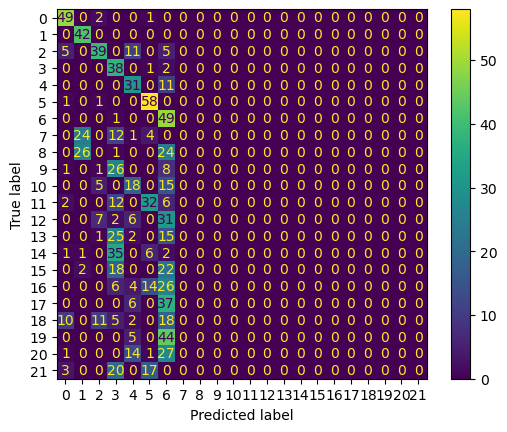

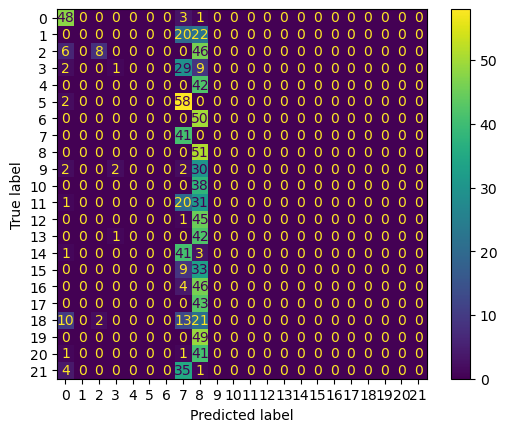

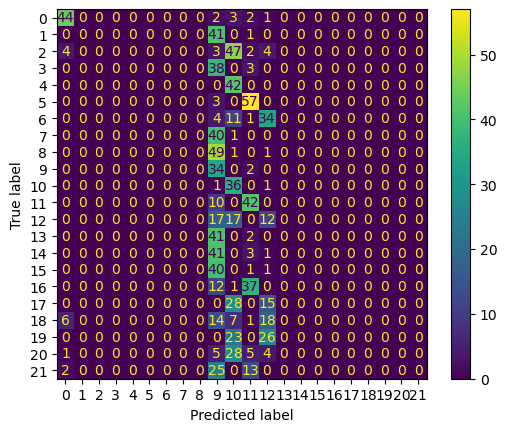

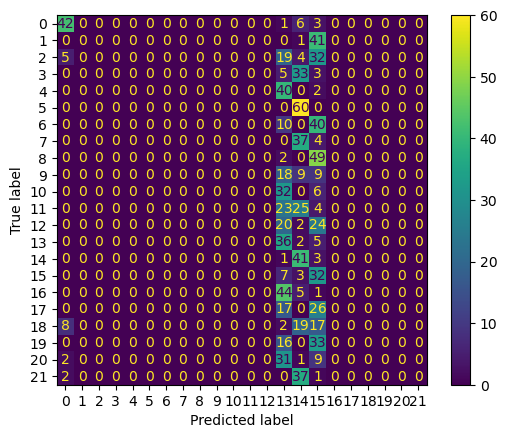

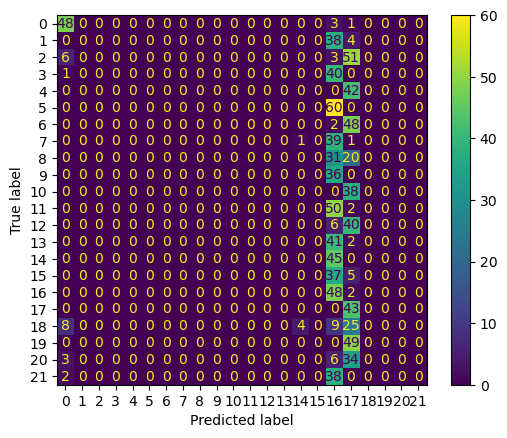

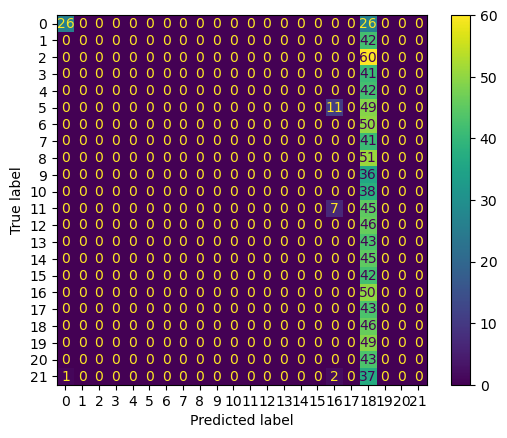

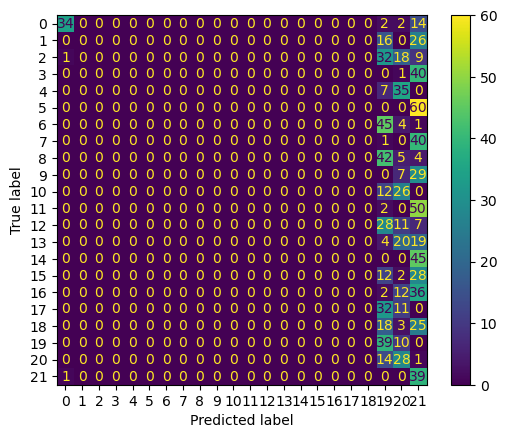

In [11]:
##Split by class, to increment by class:
class_to_group = {1:[1,2,3,4,5,6,7],2:[8,9],3:[10,11,12,13],4:[14,15,16],5:[17,18],6:[19],7:[20,21,22]}
X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group,random_state=1)
memory_values = []

#Train model
for idx,(X_train,y_train,X_test,y_test) in enumerate(zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    mem,res=model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print(f"Score accuracy group {idx}: ",model.score(X_test,y_test))
    for i in range(idx+1):
        print(f"Score accuracy group learned {i}: ",model.score(X_test_merged[i],y_test_merged[i]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))
    
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

Partial fit
Score accuracy batch 0:  0.4881422924901186
Score accuracy global:  0.5434782608695652
Memory:  256.6484375 MB
Partial fit
Score accuracy batch 1:  0.5790513833992095
Score accuracy global:  0.5731225296442688
Memory:  258.0703125 MB
Partial fit
Score accuracy batch 2:  0.5869565217391305
Score accuracy global:  0.5790513833992095
Memory:  259.33984375 MB
Partial fit
Score accuracy batch 3:  0.5988142292490118
Score accuracy global:  0.5820158102766798
Memory:  242.44921875 MB
Partial fit
Score accuracy batch 4:  0.6304347826086957
Score accuracy global:  0.5958498023715415
Memory:  243.921875 MB
Partial fit
Score accuracy batch 5:  0.6047430830039525
Score accuracy global:  0.6245059288537549
Memory:  245.2890625 MB
Partial fit
Score accuracy batch 6:  0.5830039525691699
Score accuracy global:  0.5988142292490118
Memory:  246.609375 MB
Partial fit
Score accuracy batch 7:  0.5830039525691699
Score accuracy global:  0.6146245059288538
Memory:  247.765625 MB
Partial fit
Score

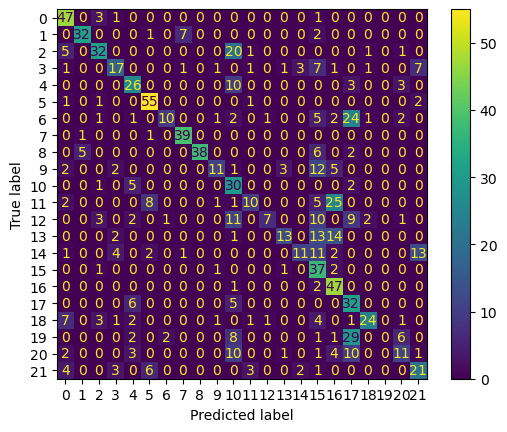

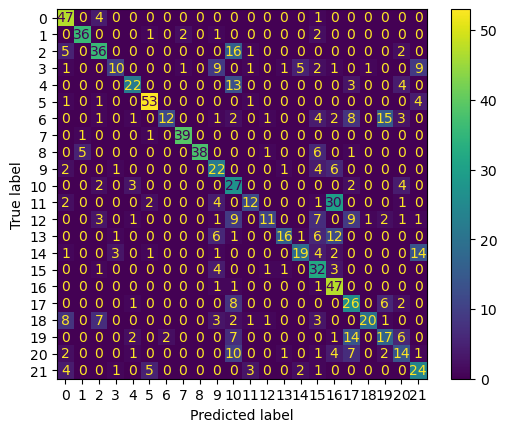

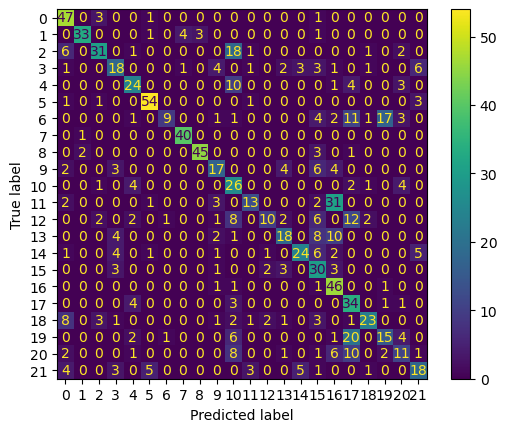

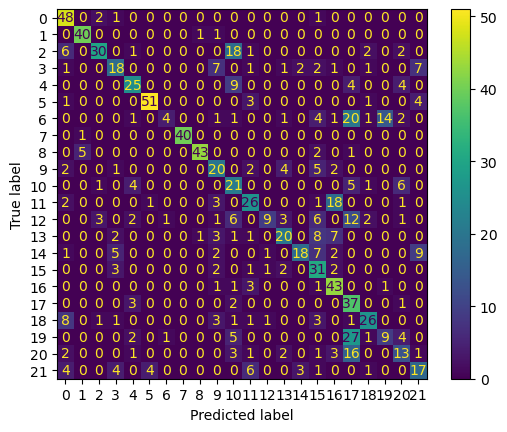

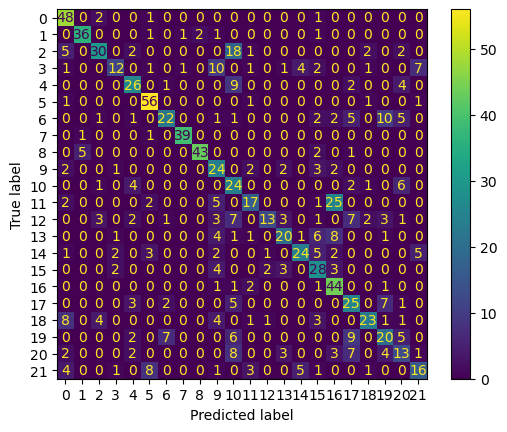

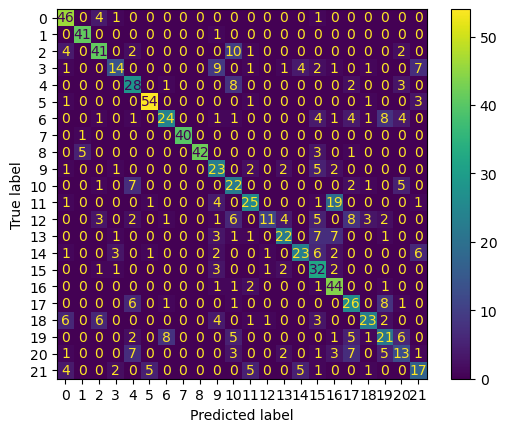

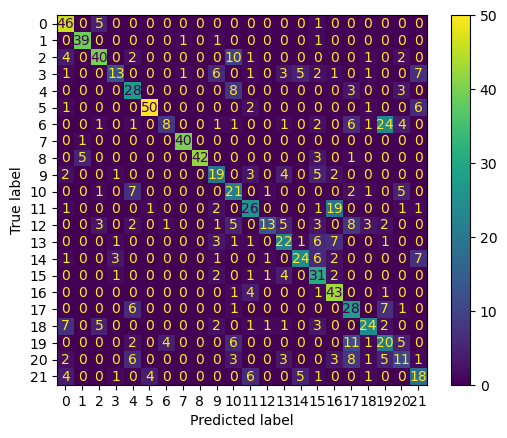

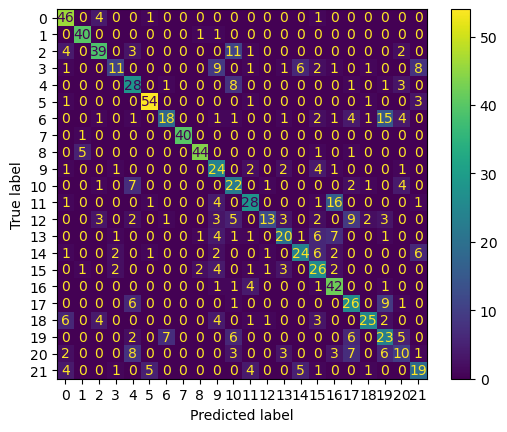

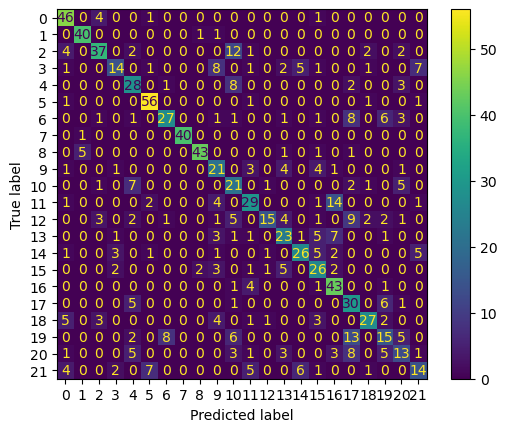

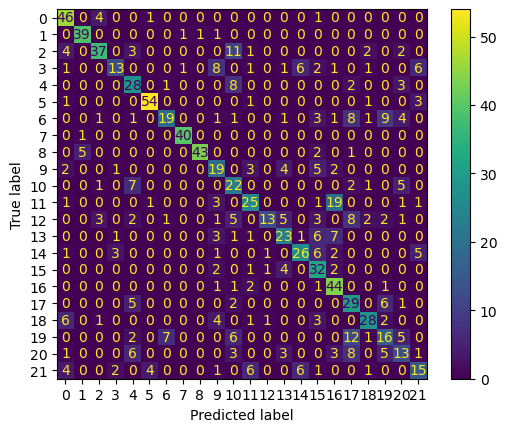

In [12]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10,random_state=1)
memory_values = []

for x in range(len(X_train_split_data)):
    mem,res=model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print(f"Score accuracy batch {x}: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))

    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")